<a href="https://www.kaggle.com/code/mdashfaquealam/face-expressioin-detection-by-ashfaque?scriptVersionId=283556115" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import os
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

# Scikit-learn
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV, train_test_split

# TensorFlow / Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


2025-12-03 07:44:43.651498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764747883.937876      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764747884.013915      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_labels = pd.read_csv("/kaggle/input/raf-db-dataset/train_labels.csv")
test_labels = pd.read_csv("/kaggle/input/raf-db-dataset/test_labels.csv")
print(train_labels.head())

                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5


In [3]:
classes = ["surprise","fear","disgust","happy","sad","angry","neutral"]
label_map = {label:(idx+1) for idx, label in enumerate(classes)}
print(label_map)

{'surprise': 1, 'fear': 2, 'disgust': 3, 'happy': 4, 'sad': 5, 'angry': 6, 'neutral': 7}


In [4]:
def load_data(dataset_dir, label_map):
    images = []
    labels = []
    for label, idx in tqdm(label_map.items()):
        folder_path = os.path.join(dataset_dir, str(idx))
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img_rgb)
                labels.append(idx)
    return np.array(images), np.array(labels)


In [5]:
train_images, train_labels = load_data("/kaggle/input/raf-db-dataset/DATASET/train",label_map)
test_images, test_labels = load_data("/kaggle/input/raf-db-dataset/DATASET/test",label_map)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
print(train_images.shape)
print(test_images.shape)


(12271, 100, 100, 3)
(3068, 100, 100, 3)


In [7]:
total_images = len(train_images)+ len(test_images)
train_percentage = (len(train_images) / total_images)*100
test_percentage = (len(test_images) / total_images)*100

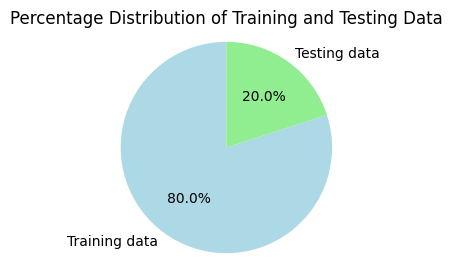

In [8]:
labels = ['Training data', 'Testing data']
sizes = [train_percentage, test_percentage]
colors = ['lightblue', 'lightgreen']
plt.figure(figsize=(3,3))
plt.pie(sizes, labels=labels, colors=colors,startangle=90, autopct='%1.1f%%')
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')
plt.show()

In [9]:
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)
train_classes = sorted(train_label_counts.keys())
train_counts = [train_label_counts[cls] for cls in train_classes]
test_classes = sorted(test_label_counts.keys())
test_counts = [test_label_counts[cls] for cls in test_classes]

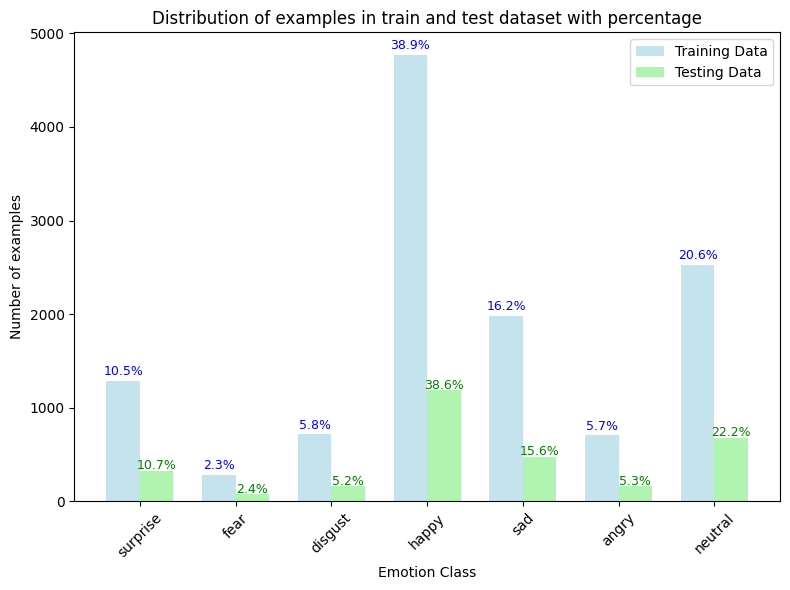

In [10]:
total_train = sum(train_counts)
total_test = sum(test_counts)
train_percentage = [(count / total_train) * 100 for count in train_counts]
test_percentage = [(count / total_test) * 100 for count in test_counts]

plt.figure(figsize=(8, 6))
x = range(len(train_classes))
bar_width = 0.35
plt.bar(x, train_counts, width=bar_width, label='Training Data', alpha=0.7, color='lightblue')
plt.bar([i + bar_width for i in x], test_counts, width=bar_width, label='Testing Data', alpha=0.7, color='lightgreen')

for i, (train_count, test_count) in enumerate(zip(train_counts, test_counts)):
    plt.text(i, train_count + 0.005 * total_train, f"{train_percentage[i]:.1f}%", ha='center', color = 'blue', fontsize=9)
    plt.text(i + bar_width, test_count + 0.005 * total_test, f"{test_percentage[i]:.1f}%", ha='center', color = 'green', fontsize=9)
plt.xticks([p + bar_width / 2 for p in x], classes, rotation = 45)
plt.xlabel('Emotion Class')
plt.ylabel('Number of examples')
plt.title('Distribution of examples in train and test dataset with percentage')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
X_train = np.concatenate([train_images, test_images], axis = 0)
Y_train = np.concatenate([train_labels, test_labels], axis = 0)
print(X_train.shape)
print(Y_train.shape)


(15339, 100, 100, 3)
(15339,)


In [12]:
X_train, Y_train = shuffle(X_train,Y_train, random_state = 42)

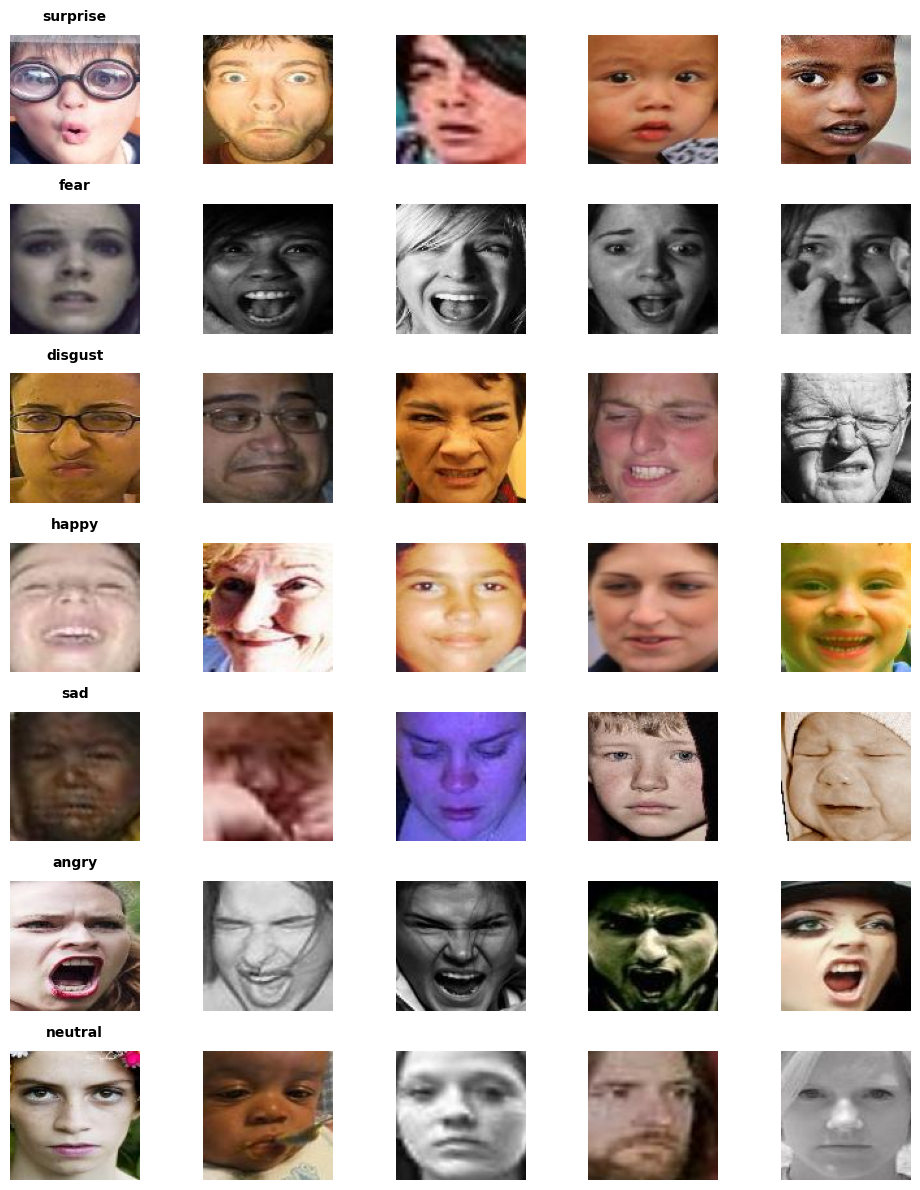

In [13]:
def show_examples(train_images, train_labels, labels, num_examples = 5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize = (10,12))

    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(train_labels) if label == i+1]
        selected_indices = np.random.choice(class_indices, num_examples, replace = False)
        axs[i,0].set_title(class_name, fontsize=10,pad = 10, fontweight = 'bold')
        # display the random images for the current class
        for j, idx in enumerate(selected_indices):
            img = train_images[idx]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()
show_examples(X_train, Y_train, classes)

In [14]:
train_data_shapes = []
for img in X_train:
    train_data_shapes.append(img.shape)

shape_counts = {}
for shape in train_data_shapes:
    if shape not in shape_counts:
        shape_counts[shape]= 0
    shape_counts[shape] += 1
sorted_shapes = sorted(shape_counts.items(), key = lambda x:x[1], reverse = True)

print("Most frequent Train images shapes")
for shape, count in sorted_shapes[:3]:
    print(f"-{shape}: {count}")
    

Most frequent Train images shapes
-(100, 100, 3): 15339


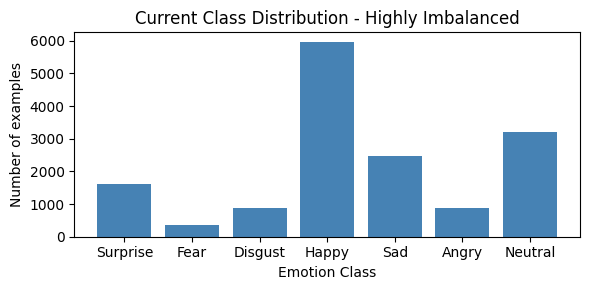

In [15]:
def plot_class_distribution(y, title):
    train_label_counts_resampled = Counter(y)
    
    train_classes_resampled = sorted(train_label_counts_resampled.keys())
    train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]

    plt.figure(figsize=(6,3))
    x_labels = ['Surprise', 'Fear', 'Disgust','Happy','Sad','Angry','Neutral']

    plt.bar(x_labels, train_counts_resampled, color = "steelblue")
    plt.xlabel('Emotion Class')
    plt.ylabel('Number of examples')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(Y_train,"Current Class Distribution - Highly Imbalanced")

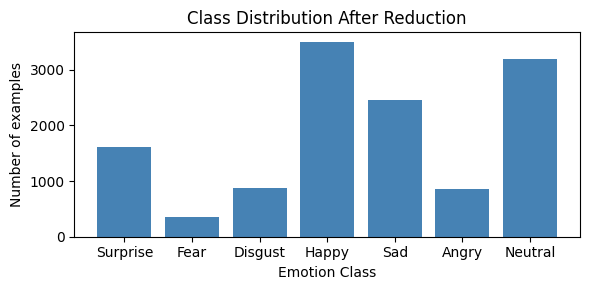

In [16]:
def reduce_class(X,y, target_class, target_size):
    # Separate the target class
    class_indices = np.where(y == target_class)[0]
    non_class_indices = np.where(y != target_class)[0]

    # Randomly sample the target class to the desired size
    reduced_class_indices = np.random.choice(class_indices, target_size, replace = False)
    # Combine the reduced class with the other classes
    final_indices = np.concatenate([reduced_class_indices, non_class_indices])
    X_reduced = X[final_indices]
    y_reduced = y[final_indices]
    return X_reduced, y_reduced

target_class = 4 # the happy class
target_size = 3500
X_train_reduced, y_train_reduced = reduce_class(X_train, Y_train, target_class, target_size)
# plot the new distribution after reduction
plot_class_distribution(y_train_reduced, "Class Distribution After Reduction")


In [17]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_classes(images, labels, target_counts):
    # Initialize the image augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        vertical_flip=False,
        horizontal_flip=True,
        channel_shift_range=50.0,
        fill_mode="nearest"
    )

    augmented_images = images.copy()
    augmented_labels = labels.copy()

    for target_class, target_count in target_counts.items():
        class_indices = np.where(labels == target_class)[0]
        class_images = images[class_indices]
        augment_count = target_count - len(class_images)

        if augment_count > 0:
            print(f"Class {target_class}: {len(class_images)} original samples, augmenting with {augment_count} new samples.")
            class_images_augmented = []
            class_labels_augmented = []

            for batch in datagen.flow(class_images, batch_size=1, seed=42):
                aug_image = batch[0].astype(np.uint8)
                class_images_augmented.append(aug_image)
                class_labels_augmented.append(target_class)
                if len(class_images_augmented) >= augment_count:
                    break

            augmented_images = np.vstack((augmented_images, np.array(class_images_augmented)))
            augmented_labels = np.hstack((augmented_labels, np.array(class_labels_augmented)))

    return augmented_images, augmented_labels
# example usage
target_counts = {1:3500, 2:3500, 3:3500, 5:3500, 6:3500, 7:3500}# target counts for each class 
X_train_augmented, y_train_augmented = augment_classes(X_train_reduced, y_train_reduced,target_counts)


Class 1: 1619 original samples, augmenting with 1881 new samples.
Class 2: 355 original samples, augmenting with 3145 new samples.
Class 3: 877 original samples, augmenting with 2623 new samples.
Class 5: 2460 original samples, augmenting with 1040 new samples.
Class 6: 867 original samples, augmenting with 2633 new samples.
Class 7: 3204 original samples, augmenting with 296 new samples.


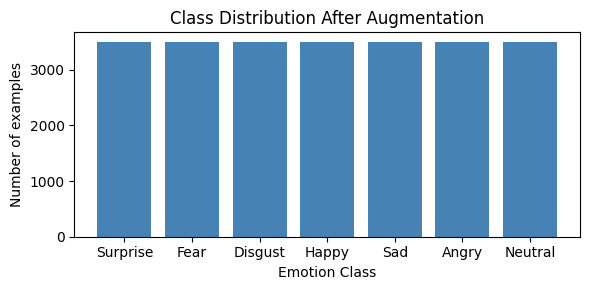

In [18]:
plot_class_distribution(y_train_augmented,"Class Distribution After Augmentation")

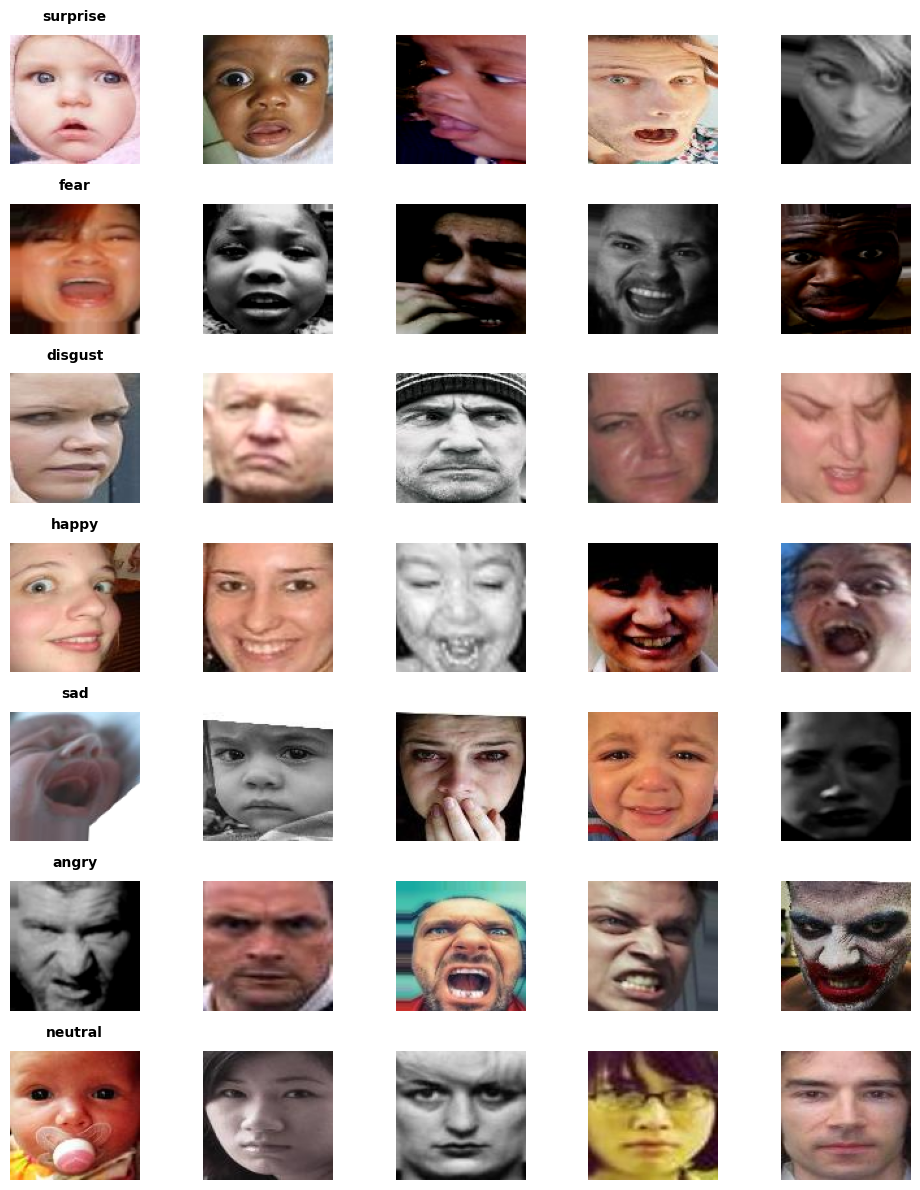

In [19]:
show_examples(X_train_augmented, y_train_augmented, classes)

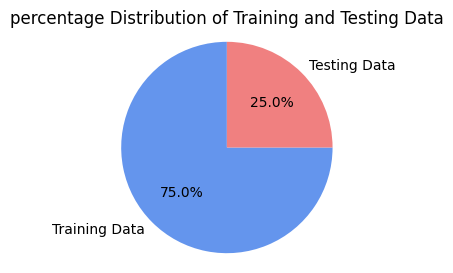

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_augmented,
                                                   y_train_augmented,
                                                   test_size = 0.25,
                                                   shuffle = True,
                                                   random_state = 42)
total_images = len(X_train) + len(X_test)

train_percentage = (len(X_train) / total_images) * 100
test_percentage = (len(X_test) / total_images) * 100

labels = ['Training Data','Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue','lightcoral']

plt.figure(figsize = (3, 3))
plt.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle = 90, colors = colors)
plt.title('percentage Distribution of Training and Testing Data')
plt.axis('equal')
plt.show()

In [21]:
def normalize_images(images):
    return images / 255.0
train_images_normalized = normalize_images(X_train)
test_images_normalized = normalize_images(X_test)

In [22]:
def reshape_images(images):
    return images.reshape((images.shape[0], 100, 100, 3))

train_images_reshaped = reshape_images(train_images_normalized)
test_images_reshaped = reshape_images(test_images_normalized)

In [23]:
print(f"Training images shape: {train_images_reshaped.shape}")
print(f"Testing images  shape: {test_images_reshaped.shape}")

Training images shape: (18375, 100, 100, 3)
Testing images  shape: (6125, 100, 100, 3)


In [24]:
Y_train_cat = to_categorical(Y_train -1, num_classes = len(classes))
Y_test_cat = to_categorical(Y_test -1, num_classes = len(classes))

In [25]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    vertical_flip = False,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
train_generator = datagen.flow(train_images_reshaped, Y_train_cat, batch_size = 64)

In [26]:
cnn_model = Sequential([
    # Convolution + Pooling layers
    Conv2D(32,(3, 3), activation='relu', input_shape=(test_images_reshaped[0].shape)),
    MaxPooling2D((2, 2)),

    Conv2D(64,(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128,(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten before dense layers
    Flatten(),

    # Fully connected layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # helps prevent overfitting
    Dense(len(classes), activation='softmax')  # output layer
])

# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-01 10:45:23.591133: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,650,951 (25.37 MB)

 Trainable params: 6,650,951 (25.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(filepath= 'best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

CNN_History = cnn_model.fit(
    train_generator,
    epochs=10,
    batch_size=32,
    validation_data=(test_images_reshaped, Y_test_cat),
    callbacks=[reduce_lr, early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
102/288 ━━━━━━━━━━━━━━━━━━━━ 2:06 682ms/step - accuracy: 0.1849 - loss: 2.0231

In [ ]:
train_loss = CNN_History.history['loss']
val_loss = CNN_History.history['val_loss']
train_accuracy = CNN_History.history['accuracy']
val_accuracy = CNN_History.history['val_accuracy']
fig,ax = plt.subplots(1,2, figsize = (8,4))

ax[0].plot(train_loss, label = 'Training Loss',color='Red')
ax[0].plot(val_loss, label = 'Validation Loss', color = 'green')
ax[0].set_title('Loss Curves')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0,2])
ax[0].grid(alpha = 0.3)

ax[1].plot(train_accuracy, label = 'Training Accuracy', color = 'red')
ax[1].plot(val_accuracy, label = 'Validation Accuracy', color = 'green')
ax[1].set_title('Accuracy Curves')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim([0,1])
ax[1].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

In [ ]:
train_CNNresult = cnn_model.evaluate(train_images_reshaped, Y_train_cat)
test_CNNresult = cnn_model.evaluate(test_images_reshaped, Y_test_cat)

print("Train loss:{:.2f}%".format(train_CNNresult[0]*100))
print("Train Accuracy:{:.2f}%".format(train_CNNresult[1]*100))

print("\nTest loss:{:.2f}%".format(test_CNNresult[0]*100))
print("Test Accuracy:{:.2f}%".format(test_CNNresult[1]*100))

